# NaiveBayes

## Librerias Utilizadas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics as mt
import calendar

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Limpieza de datos

Transformamos las variables necesarias a formato numérico pedido por el modelo

In [61]:
def procesar_csv(df):
    from sklearn import preprocessing
    
    # Convertirmos las columnas origin y destination a variables numericas 
    le = preprocessing.LabelEncoder()
    ciudades = ((pd.concat([df['origin'], df['destination']], ignore_index = True).drop_duplicates()).reset_index())[0]
    le.fit(ciudades)
    
    origin_as_int = le.fit_transform(df['origin'])
    destination_as_int = le.fit_transform(df["destination"])
    
    df["origin_int"] = origin_as_int
    df.drop('origin', axis=1, inplace=True)
    
    df["destination_int"] = destination_as_int
    df.drop('destination', axis=1, inplace=True)

    # Transformamos Columnas Continuas a Discretas
    revenues_usd_discr = pd.qcut(df["revenues_usd"], 10, [1,2,3,4,5,6,7,8,9,10] )
    df["revenues_usd_discr"] = revenues_usd_discr
    df.drop('revenues_usd', axis=1, inplace=True)
    
    # Cambiamos el formato del date y departure_time para saber el mes de la compra y el horario en el que se compra
    df["date"] = pd.to_datetime(df["date"], errors='coerce')
    df["mes"] = pd.DatetimeIndex(df["date"]).month
    
    df.departure_time = pd.to_datetime(df.departure_time, errors='coerce')
    bins = [0,12,18,24]
    labels = ["Mañana","Tarde","Noche"]
    le.fit(labels)
    df["hora"] = pd.DatetimeIndex(df["departure_time"]).hour
    #df['horario'] = pd.cut(df["departure_time"].dt.hour, bins, labels=labels, right=False)
    #df['horario'] = le.fit_transform(df["horario"])
    
    df.drop('departure_time', axis=1, inplace=True)
    df.drop('date', axis=1, inplace=True)
    
    
    le.fit(df["fligth_number"])
    df["fligth_number"] = le.fit_transform(df["fligth_number"])

    
    # Eliminar columnas sin uso
    df.drop('Unnamed: 0', axis=1, inplace=True)
    
    # retornamos el data frame modificado sin valore nulos.
    return df.dropna()

In [75]:
# Leemos los datos
df = pd.read_csv("ALUMNOS-trainData.csv")
df_procesado = df.copy()

# transformamos los datos a binarios
df_procesado["Labels"] = np.where(df_procesado["noshow"] >= 4, 1,0)

# Procesamos los datos con la funcion procesar_csv()
df_procesado = procesar_csv(df_procesado)

# Definimos nuestra columna target
target = df_procesado['Labels']

# La eliminamos del dataframe
df_procesado.drop('noshow', axis=1, inplace=True)
df_procesado.drop('Labels', axis=1, inplace=True)

In [76]:
df_procesado.columns

Index(['fligth_number', 'distance', 'denied_boarding', 'pax_midlow',
       'pax_high', 'pax_midhigh', 'pax_low', 'pax_freqflyer', 'group_bookings',
       'out_of_stock', 'dom_cnx', 'int_cnx', 'p2p', 'capacity', 'bookings',
       'origin_int', 'destination_int', 'revenues_usd_discr', 'mes', 'hora'],
      dtype='object')

In [77]:
df_procesado.drop('out_of_stock', axis=1, inplace=True)

### Se usará K-Fold Cross Validation con Undersampling para calcular los Score
Debido a que las clases se encuentran desbalanceadas, se utilizó una muestra más pequeña de la clase 1 para evitar el overfitting de esa clase.

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

title = "Learning Curves (Naive Bayes)"
cv = KFold(n_splits=50, shuffle = True, random_state=0)
estimator = GaussianNB()
plot_learning_curve(
    estimator, title, df_procesado, target, cv=cv, n_jobs=-1
)


## MultinomialNB (alpha = 0,1,10,100)

In [ ]:
TrainF1Score_general = []
TestF1Score_general = []

for j in [0,1,10,100]:
#Crear un objeto de KFold cross validation
    k = 200
    kf = KFold(n_splits = k, shuffle = True)

    NB = MultinomialNB(alpha = j)
    #Crear arreglos para guardar los errores de cada fold (tanto para entrenamiento como test).
    F1Train = np.zeros(k)
    F1Test = np.zeros(k)

    i=0
    #Aplicar K-fold cross validation
    for train_index, test_index in kf.split(df_procesado[['origin_int','destination_int','mes','hora']]):
        #extraer los datos de entrenamiento y test
            #Train
            trainData = df_procesado[['origin_int','destination_int','mes','hora']].iloc[train_index, :]
            trainLabel = target.iloc[train_index]

            yes_overbook = trainData[trainLabel == 1]
            no_overbook = trainData[trainLabel == 0]

            yes_overbook = yes_overbook.sample(no_overbook.shape[0])

            trainData = yes_overbook.append(no_overbook)
            trainLabel = pd.Series([1]*no_overbook.shape[0]+[0]*no_overbook.shape[0])

            #Test
            testData = df_procesado[['origin_int','destination_int','mes','hora']].iloc[test_index, :]
            testLabel = target.iloc[test_index]

            #Entrenar el modelo usando los datos de entrenamiento
            NB = NB.fit(trainData, trainLabel)

            #Predecir los valores de TrainData y calcule su error
            prediccion = NB.predict(trainData)
            F1Train[i] = mt.f1_score(trainLabel, prediccion, pos_label = 0)

            #Prediga los valores de testData y calcule su error
            prediccion = NB.predict(testData)
            F1Test[i] = mt.f1_score(testLabel, prediccion, pos_label = 0)

            i+=1

            if(i == k):
                TrainF1Score_general.append(F1Train)
                TestF1Score_general.append(F1Test)

            print(i, end=" ")
    print("F1-score modelo para training: ", TrainF1Score_general[len(TrainF1Score_general)-1].mean(), "+-", TrainF1Score_general[len(TrainF1Score_general)-1].std())   
    print("F1-score modelo para test: ", TestF1Score_general[len(TestF1Score_general)-1].mean(), "+-", TestF1Score_general[len(TestF1Score_general)-1].std())  

In [ ]:
res = [None] * (len(TestF1Score_general))
laplace = [0,1,10,100]
variables = 1
for i in range(len(TestF1Score_general)):
    res[i] = [laplace[i], TrainAcc_general[i].mean(), TrainAcc_general[i].std(), TestAcc_general[i].mean(),TestAcc_general[i].std(), TrainF1Score_general[i].mean(),TrainF1Score_general[i].std(), TestF1Score_general[i].mean(),TestF1Score_general[i].std()]
    variables += 1

resultados = pd.DataFrame(res, columns = ['Laplace','Accuracy Train Mean', 'Accuracy Train Std','Accuracy Test Mean','Accuracy Test Std','F1 Train Mean','F1 Train std','F1 Test Mean','F1 Test Std'])
resultados

In [ ]:
plt.figure(figsize=(8, 8))

plt.boxplot(TestF1Score_general)
plt.xticks([1, 2, 3, 4], ["0","1","10","100"])
plt.legend()
plt.show()

## GaussianNB (alpha = 0,1e-09,1e-05,0.1)

In [7]:
#df_procesado.drop('origin_int', axis=1, inplace=True)
#df_procesado.drop('destination_int', axis=1, inplace=True)
len(df_procesado.columns)

19

In [28]:
Gaussian0 = []
Gaussian1 = []
Gaussian2 = []
Gaussian3 = []

m = 1
while(m < len(df_procesado.columns)):
    display(df_procesado.iloc[:,:m])
    TrainF1Score_general = []
    TestF1Score_general = []

    for j in [0,1e-09,1e-05,0.1]:
    #Crear un objeto de KFold cross validation
        k = 50
        kf = KFold(n_splits = k, shuffle = True, random_state = 42)

        NB = GaussianNB(var_smoothing = j)
        #Crear arreglos para guardar los errores de cada fold (tanto para entrenamiento como test).
        F1Train = np.zeros(k)
        F1Test = np.zeros(k)

        i=0
        #Aplicar K-fold cross validation
        for train_index, test_index in kf.split(df_procesado.iloc[:,:m]):
            #extraer los datos de entrenamiento y test
                #Train
                trainData = df_procesado.iloc[:,:m].iloc[train_index, :]
                trainLabel = target.iloc[train_index]

                yes_overbook = trainData[trainLabel == 1]
                no_overbook = trainData[trainLabel == 0]

                yes_overbook = yes_overbook.sample(no_overbook.shape[0])

                trainData = yes_overbook.append(no_overbook)
                trainLabel = pd.Series([1]*no_overbook.shape[0]+[0]*no_overbook.shape[0])

                #Test
                testData = df_procesado.iloc[:,:m].iloc[test_index, :]
                testLabel = target.iloc[test_index]

                #Entrenar el modelo usando los datos de entrenamiento
                NB = NB.fit(trainData, trainLabel)

                #Predecir los valores de TrainData y calcule su error
                prediccion = NB.predict(trainData)
                F1Train[i] = mt.f1_score(trainLabel, prediccion, pos_label = 0)

                #Prediga los valores de testData y calcule su error
                prediccion = NB.predict(testData)
                F1Test[i] = mt.f1_score(testLabel, prediccion, pos_label = 0)

                i+=1
                if(i == k):
                    TrainF1Score_general.append(F1Train)
                    TestF1Score_general.append(F1Test)

                print(i, end=" ")
        if j == 0: Gaussian0.append([TrainF1Score_general[len(TrainF1Score_general)-1],TestF1Score_general[len(TestF1Score_general)-1]])
        if j == 1e-09: Gaussian1.append([TrainF1Score_general[len(TrainF1Score_general)-1],TestF1Score_general[len(TestF1Score_general)-1]])
        if j == 1e-05: Gaussian2.append([TrainF1Score_general[len(TrainF1Score_general)-1],TestF1Score_general[len(TestF1Score_general)-1]])
        if j == 0.1: Gaussian3.append([TrainF1Score_general[len(TrainF1Score_general)-1],TestF1Score_general[len(TestF1Score_general)-1]])
        print("\nF1-score modelo para training: ", TrainF1Score_general[len(TrainF1Score_general)-1].mean(), "+-", TrainF1Score_general[len(TrainF1Score_general)-1].std())   
        print("F1-score modelo para test: ", TestF1Score_general[len(TestF1Score_general)-1].mean(), "+-", TestF1Score_general[len(TestF1Score_general)-1].std())  
    m+=1

,fligth_number
0,3799
1,2869
2,3776
3,2267
4,3051
...,...
999885,2252
999886,2567
999887,3886
999888,3045


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5345243091863068 +- 0.0005657128382479011
F1-score modelo para test:  0.4412440624045715 +- 0.0047149522872117
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5346867854764122 +- 0.0006089933878194698
F1-score modelo para test:  0.44137226357176707 +- 0.0047195501818094255
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5345872454476318 +- 0.0006792863744648564
F1-score modelo para test:  0.44131358262058934 +- 0.004706497137896609
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 

,fligth_number,distance
0,3799,1394
1,2869,489
2,3776,2180
3,2267,524
4,3051,1170
...,...,...
999885,2252,552
999886,2567,3934
999887,3886,1430
999888,3045,1091


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5580093161958186 +- 0.002502525238885072
F1-score modelo para test:  0.4564742286524542 +- 0.005508447906216066
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5582807146393483 +- 0.0025834415783011584
F1-score modelo para test:  0.45659966602957025 +- 0.005217900486136042
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5584534616574406 +- 0.0020244620589454708
F1-score modelo para test:  0.45673438601696353 +- 0.004895278194242615
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 

,fligth_number,distance,denied_boarding
0,3799,1394,0
1,2869,489,0
2,3776,2180,0
3,2267,524,0
4,3051,1170,0
...,...,...,...
999885,2252,552,0
999886,2567,3934,0
999887,3886,1430,0
999888,3045,1091,0


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.3021797138425246 +- 0.021189402845254987
F1-score modelo para test:  0.27950317044673484 +- 0.01818915773010721
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.29847459882663363 +- 0.021630334114136934
F1-score modelo para test:  0.2761873245796814 +- 0.01978280452475966
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5557188210378174 +- 0.001969412917819616
F1-score modelo para test:  0.45517062960054816 +- 0.005052547101006921
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 

,fligth_number,distance,denied_boarding,pax_midlow
0,3799,1394,0,94
1,2869,489,0,100
2,3776,2180,0,7
3,2267,524,0,54
4,3051,1170,0,21
...,...,...,...,...
999885,2252,552,0,25
999886,2567,3934,0,129
999887,3886,1430,0,2
999888,3045,1091,0,67


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.34016291091975537 +- 0.027322034613700256
F1-score modelo para test:  0.311060206429905 +- 0.022237777986306585
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.35044659620927904 +- 0.025311805390170878
F1-score modelo para test:  0.3194557074087413 +- 0.021152324171155465
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.572607029498856 +- 0.00043298414452041503
F1-score modelo para test:  0.4700023733976962 +- 0.004759861759701706
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48

,fligth_number,distance,denied_boarding,pax_midlow,pax_high
0,3799,1394,0,94,2
1,2869,489,0,100,4
2,3776,2180,0,7,1
3,2267,524,0,54,4
4,3051,1170,0,21,88
...,...,...,...,...,...
999885,2252,552,0,25,12
999886,2567,3934,0,129,3
999887,3886,1430,0,2,1
999888,3045,1091,0,67,2


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.31593996655145895 +- 0.01282482748502454
F1-score modelo para test:  0.28962938582078107 +- 0.012730823614189717
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.32188776512327694 +- 0.0151708932688041
F1-score modelo para test:  0.29482467281994157 +- 0.014631138417217637
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5667808324552291 +- 0.0011626475362895245
F1-score modelo para test:  0.46737072283783193 +- 0.004756654875195146
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 4

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh
0,3799,1394,0,94,2,28
1,2869,489,0,100,4,4
2,3776,2180,0,7,1,5
3,2267,524,0,54,4,7
4,3051,1170,0,21,88,18
...,...,...,...,...,...,...
999885,2252,552,0,25,12,20
999886,2567,3934,0,129,3,19
999887,3886,1430,0,2,1,0
999888,3045,1091,0,67,2,7


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.3172671448477134 +- 0.016241355187095876
F1-score modelo para test:  0.29103249539715753 +- 0.014230051979481175
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.321573566906756 +- 0.012489460979549815
F1-score modelo para test:  0.29510636694189746 +- 0.01104607118629544
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5658659344736876 +- 0.0016709151252932359
F1-score modelo para test:  0.4671527082958083 +- 0.005085344375091797
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low
0,3799,1394,0,94,2,28,94
1,2869,489,0,100,4,4,87
2,3776,2180,0,7,1,5,64
3,2267,524,0,54,4,7,21
4,3051,1170,0,21,88,18,82
...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4
999886,2567,3934,0,129,3,19,121
999887,3886,1430,0,2,1,0,108
999888,3045,1091,0,67,2,7,42


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4626475881991647 +- 0.013548658180197307
F1-score modelo para test:  0.4004699061176691 +- 0.011203704855186333
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4630206135982391 +- 0.012403964724210029
F1-score modelo para test:  0.40050643226385274 +- 0.009224289138315956
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5938579626496976 +- 0.001048086981641473
F1-score modelo para test:  0.4883471352274195 +- 0.004427986526824899
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer
0,3799,1394,0,94,2,28,94,22
1,2869,489,0,100,4,4,87,25
2,3776,2180,0,7,1,5,64,2
3,2267,524,0,54,4,7,21,4
4,3051,1170,0,21,88,18,82,0
...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12
999886,2567,3934,0,129,3,19,121,2
999887,3886,1430,0,2,1,0,108,20
999888,3045,1091,0,67,2,7,42,16


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.48377975332901896 +- 0.009614638961250546
F1-score modelo para test:  0.41694706451222335 +- 0.008764999078219442
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.480089438680514 +- 0.011313946884221965
F1-score modelo para test:  0.41434433029122003 +- 0.008124762272615006
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.6032142389600776 +- 0.0007244189970627229
F1-score modelo para test:  0.4955022700658456 +- 0.004490596243689967
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 4

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings
0,3799,1394,0,94,2,28,94,22,19
1,2869,489,0,100,4,4,87,25,0
2,3776,2180,0,7,1,5,64,2,0
3,2267,524,0,54,4,7,21,4,0
4,3051,1170,0,21,88,18,82,0,88
...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0
999886,2567,3934,0,129,3,19,121,2,20
999887,3886,1430,0,2,1,0,108,20,36
999888,3045,1091,0,67,2,7,42,16,0


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.3375270857380348 +- 0.012070123036159773
F1-score modelo para test:  0.3091331723490964 +- 0.011839905070133033
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.34090123378488824 +- 0.012193890552659837
F1-score modelo para test:  0.3120868192061764 +- 0.011271485634026895
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5299168071742895 +- 0.002657114562149486
F1-score modelo para test:  0.451444435904853 +- 0.0056195336621925355
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx
0,3799,1394,0,94,2,28,94,22,19,1
1,2869,489,0,100,4,4,87,25,0,19
2,3776,2180,0,7,1,5,64,2,0,0
3,2267,524,0,54,4,7,21,4,0,26
4,3051,1170,0,21,88,18,82,0,88,23
...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64
999886,2567,3934,0,129,3,19,121,2,20,0
999887,3886,1430,0,2,1,0,108,20,36,7
999888,3045,1091,0,67,2,7,42,16,0,34


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.3459194212943675 +- 0.010730526551818928
F1-score modelo para test:  0.3153579212400113 +- 0.009151437664121293
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.3471512410642033 +- 0.010132057731592722
F1-score modelo para test:  0.3164682092890759 +- 0.010082948398406002
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5314148422531979 +- 0.0021133048805405097
F1-score modelo para test:  0.45295192873968226 +- 0.005821199205764778
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx,int_cnx
0,3799,1394,0,94,2,28,94,22,19,1,0
1,2869,489,0,100,4,4,87,25,0,19,9
2,3776,2180,0,7,1,5,64,2,0,0,10
3,2267,524,0,54,4,7,21,4,0,26,0
4,3051,1170,0,21,88,18,82,0,88,23,3
...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64,9
999886,2567,3934,0,129,3,19,121,2,20,0,118
999887,3886,1430,0,2,1,0,108,20,36,7,0
999888,3045,1091,0,67,2,7,42,16,0,34,2


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.3312358763049722 +- 0.008419515094352629
F1-score modelo para test:  0.30310852286372575 +- 0.008509077443244722
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.3333007722875557 +- 0.0096308100806492
F1-score modelo para test:  0.3047459936540968 +- 0.009762666881398591
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5170570006978268 +- 0.0038813634435391933
F1-score modelo para test:  0.4458056565345416 +- 0.006091560128863361
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 4

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx,int_cnx,p2p
0,3799,1394,0,94,2,28,94,22,19,1,0,239
1,2869,489,0,100,4,4,87,25,0,19,9,192
2,3776,2180,0,7,1,5,64,2,0,0,10,69
3,2267,524,0,54,4,7,21,4,0,26,0,64
4,3051,1170,0,21,88,18,82,0,88,23,3,183
...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64,9,0
999886,2567,3934,0,129,3,19,121,2,20,0,118,156
999887,3886,1430,0,2,1,0,108,20,36,7,0,124
999888,3045,1091,0,67,2,7,42,16,0,34,2,98


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.45126628451107204 +- 0.00932448382174908
F1-score modelo para test:  0.39844825262416117 +- 0.009289278210300057
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4538374278951269 +- 0.009370204566933507
F1-score modelo para test:  0.4000924430859545 +- 0.00965824286576881
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5778476709781265 +- 0.0017887378850876153
F1-score modelo para test:  0.4875573336416674 +- 0.005773799420366516
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx,int_cnx,p2p,capacity
0,3799,1394,0,94,2,28,94,22,19,1,0,239,174.0
1,2869,489,0,100,4,4,87,25,0,19,9,192,174.0
2,3776,2180,0,7,1,5,64,2,0,0,10,69,218.0
3,2267,524,0,54,4,7,21,4,0,26,0,64,174.0
4,3051,1170,0,21,88,18,82,0,88,23,3,183,144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64,9,0,144.0
999886,2567,3934,0,129,3,19,121,2,20,0,118,156,168.0
999887,3886,1430,0,2,1,0,108,20,36,7,0,124,218.0
999888,3045,1091,0,67,2,7,42,16,0,34,2,98,144.0


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5311371733769111 +- 0.007259244854396069
F1-score modelo para test:  0.45882653263453654 +- 0.006720894714457935
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5341332420716879 +- 0.00486117488343043
F1-score modelo para test:  0.4610965258306416 +- 0.005773817585097495
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.6069644426927023 +- 0.0008949190006214273
F1-score modelo para test:  0.5075439344998849 +- 0.005099645820855873
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx,int_cnx,p2p,capacity,bookings
0,3799,1394,0,94,2,28,94,22,19,1,0,239,174.0,240
1,2869,489,0,100,4,4,87,25,0,19,9,192,174.0,220
2,3776,2180,0,7,1,5,64,2,0,0,10,69,218.0,79
3,2267,524,0,54,4,7,21,4,0,26,0,64,174.0,90
4,3051,1170,0,21,88,18,82,0,88,23,3,183,144.0,209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64,9,0,144.0,73
999886,2567,3934,0,129,3,19,121,2,20,0,118,156,168.0,274
999887,3886,1430,0,2,1,0,108,20,36,7,0,124,218.0,131
999888,3045,1091,0,67,2,7,42,16,0,34,2,98,144.0,134


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5622601342516902 +- 0.004004137690569897
F1-score modelo para test:  0.47911845262150593 +- 0.0060643742031837805
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5634046033832738 +- 0.005121695596274207
F1-score modelo para test:  0.479875552263502 +- 0.005915424720898552
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.6101951066275134 +- 0.000738820221137211
F1-score modelo para test:  0.5065724007818033 +- 0.005078305686979996
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx,int_cnx,p2p,capacity,bookings,origin_int
0,3799,1394,0,94,2,28,94,22,19,1,0,239,174.0,240,12
1,2869,489,0,100,4,4,87,25,0,19,9,192,174.0,220,79
2,3776,2180,0,7,1,5,64,2,0,0,10,69,218.0,79,122
3,2267,524,0,54,4,7,21,4,0,26,0,64,174.0,90,27
4,3051,1170,0,21,88,18,82,0,88,23,3,183,144.0,209,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64,9,0,144.0,73,143
999886,2567,3934,0,129,3,19,121,2,20,0,118,156,168.0,274,79
999887,3886,1430,0,2,1,0,108,20,36,7,0,124,218.0,131,62
999888,3045,1091,0,67,2,7,42,16,0,34,2,98,144.0,134,53


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5644559833651916 +- 0.003908887083142371
F1-score modelo para test:  0.48153560378288235 +- 0.005579861526672531
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5647570344769801 +- 0.004763137793485406
F1-score modelo para test:  0.48154500397853406 +- 0.0052372949854490826
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.6115556844797231 +- 0.0006147370088769343
F1-score modelo para test:  0.5086179185659734 +- 0.004814597452078571
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx,int_cnx,p2p,capacity,bookings,origin_int,destination_int
0,3799,1394,0,94,2,28,94,22,19,1,0,239,174.0,240,12,125
1,2869,489,0,100,4,4,87,25,0,19,9,192,174.0,220,79,143
2,3776,2180,0,7,1,5,64,2,0,0,10,69,218.0,79,122,116
3,2267,524,0,54,4,7,21,4,0,26,0,64,174.0,90,27,33
4,3051,1170,0,21,88,18,82,0,88,23,3,183,144.0,209,51,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64,9,0,144.0,73,143,27
999886,2567,3934,0,129,3,19,121,2,20,0,118,156,168.0,274,79,57
999887,3886,1430,0,2,1,0,108,20,36,7,0,124,218.0,131,62,125
999888,3045,1091,0,67,2,7,42,16,0,34,2,98,144.0,134,53,126


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5651745298856067 +- 0.004037931835606802
F1-score modelo para test:  0.48207094141363094 +- 0.005442182416321808
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5661155654192843 +- 0.003775743339989042
F1-score modelo para test:  0.4826860139776189 +- 0.005441291365754544
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.6118836874352627 +- 0.0006959553357389395
F1-score modelo para test:  0.5090884383093707 +- 0.004827103769009648
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx,int_cnx,p2p,capacity,bookings,origin_int,destination_int,revenues_usd_discr
0,3799,1394,0,94,2,28,94,22,19,1,0,239,174.0,240,12,125,6
1,2869,489,0,100,4,4,87,25,0,19,9,192,174.0,220,79,143,2
2,3776,2180,0,7,1,5,64,2,0,0,10,69,218.0,79,122,116,8
3,2267,524,0,54,4,7,21,4,0,26,0,64,174.0,90,27,33,6
4,3051,1170,0,21,88,18,82,0,88,23,3,183,144.0,209,51,55,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64,9,0,144.0,73,143,27,8
999886,2567,3934,0,129,3,19,121,2,20,0,118,156,168.0,274,79,57,10
999887,3886,1430,0,2,1,0,108,20,36,7,0,124,218.0,131,62,125,7
999888,3045,1091,0,67,2,7,42,16,0,34,2,98,144.0,134,53,126,5


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5653294594214315 +- 0.0033667165189478383
F1-score modelo para test:  0.48297136154499737 +- 0.005814886013612048
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5647905116629578 +- 0.004064687007820901
F1-score modelo para test:  0.4823598506029787 +- 0.005979878555736008
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.6107059698574805 +- 0.0006301221738507936
F1-score modelo para test:  0.5086135625995623 +- 0.004817852238957668
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 4

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx,int_cnx,p2p,capacity,bookings,origin_int,destination_int,revenues_usd_discr,mes
0,3799,1394,0,94,2,28,94,22,19,1,0,239,174.0,240,12,125,6,11
1,2869,489,0,100,4,4,87,25,0,19,9,192,174.0,220,79,143,2,5
2,3776,2180,0,7,1,5,64,2,0,0,10,69,218.0,79,122,116,8,5
3,2267,524,0,54,4,7,21,4,0,26,0,64,174.0,90,27,33,6,2
4,3051,1170,0,21,88,18,82,0,88,23,3,183,144.0,209,51,55,8,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64,9,0,144.0,73,143,27,8,10
999886,2567,3934,0,129,3,19,121,2,20,0,118,156,168.0,274,79,57,10,5
999887,3886,1430,0,2,1,0,108,20,36,7,0,124,218.0,131,62,125,7,4
999888,3045,1091,0,67,2,7,42,16,0,34,2,98,144.0,134,53,126,5,4


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5649712310148761 +- 0.003865974159370953
F1-score modelo para test:  0.48289665555597033 +- 0.005328228872008772
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5658444686204104 +- 0.004099257007178201
F1-score modelo para test:  0.48340476592174875 +- 0.005939343667030381
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.6103177928403565 +- 0.0006882916011253095
F1-score modelo para test:  0.5084983113276488 +- 0.004763126119364119
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 4

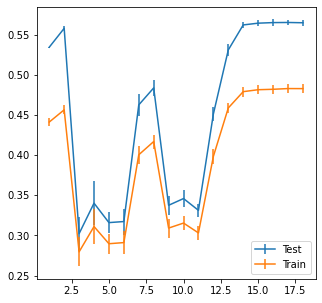

In [38]:
TrainMeans = []
TrainSTD = []
TestMeans = []
TestSTD = []

for i in range(len(Gaussian0)):
    TrainMeans.append(Gaussian0[i][0].mean())
    TrainSTD.append(Gaussian0[i][0].std())
    TestMeans.append(Gaussian0[i][1].mean())
    TestSTD.append(Gaussian0[i][1].std())

plt.figure(figsize=(5,5))
plt.errorbar(range(1,len(df_procesado.columns)), TrainMeans, TrainSTD, label = "Test")
plt.errorbar(range(1,len(df_procesado.columns)), TestMeans, TestSTD, label = "Train")
plt.legend()
plt.show()

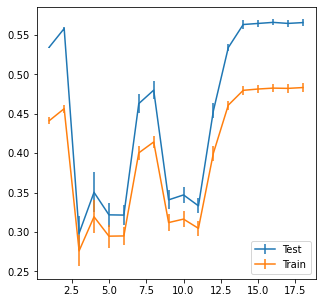

In [35]:
TrainMeans = []
TrainSTD = []
TestMeans = []
TestSTD = []

for i in range(len(Gaussian1)):
    TrainMeans.append(Gaussian1[i][0].mean())
    TrainSTD.append(Gaussian1[i][0].std())
    TestMeans.append(Gaussian1[i][1].mean())
    TestSTD.append(Gaussian1[i][1].std())

plt.figure(figsize=(5,5))
plt.errorbar(range(1,len(df_procesado.columns)), TrainMeans, TrainSTD, label = "Test")
plt.errorbar(range(1,len(df_procesado.columns)), TestMeans, TestSTD, label = "Train")
plt.legend()
plt.show()

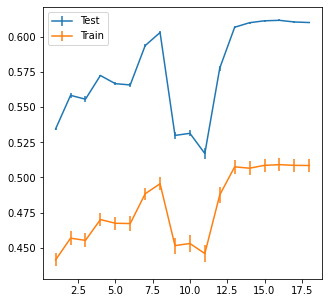

In [36]:
TrainMeans = []
TrainSTD = []
TestMeans = []
TestSTD = []

for i in range(len(Gaussian2)):
    TrainMeans.append(Gaussian2[i][0].mean())
    TrainSTD.append(Gaussian2[i][0].std())
    TestMeans.append(Gaussian2[i][1].mean())
    TestSTD.append(Gaussian2[i][1].std())

plt.figure(figsize=(5,5))
plt.errorbar(range(1,len(df_procesado.columns)), TrainMeans, TrainSTD, label = "Test")
plt.errorbar(range(1,len(df_procesado.columns)), TestMeans, TestSTD, label = "Train")
plt.legend()
plt.show()

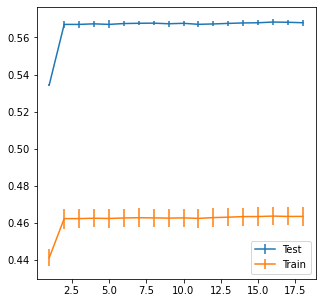

In [37]:
TrainMeans = []
TrainSTD = []
TestMeans = []
TestSTD = []

for i in range(len(Gaussian3)):
    TrainMeans.append(Gaussian3[i][0].mean())
    TrainSTD.append(Gaussian3[i][0].std())
    TestMeans.append(Gaussian3[i][1].mean())
    TestSTD.append(Gaussian3[i][1].std())

plt.figure(figsize=(5,5))
plt.errorbar(range(1,len(df_procesado.columns)), TrainMeans, TrainSTD, label = "Test")
plt.errorbar(range(1,len(df_procesado.columns)), TestMeans, TestSTD, label = "Train")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

plt.figure(figsize=(10, 10))
plt.errorbar(resultados["# Variables"], resultados["Accuracy Test Mean"], resultados["Accuracy Test Std"], label = "Test")
plt.errorbar(resultados["# Variables"], resultados["Accuracy Train Mean"], resultados["Accuracy Test Std"], label = "Train")
plt.legend()
plt.show()

plt.figure(figsize=(10, 10))
plt.errorbar(resultados["# Variables"], resultados["F1 Test Mean"], resultados["F1 Test Std"], label = "Test")
plt.errorbar(resultados["# Variables"], resultados["F1 Train Mean"], resultados["F1 Test Std"], label = "Train")
plt.legend()
plt.show()

No handles with labels found to put in legend.


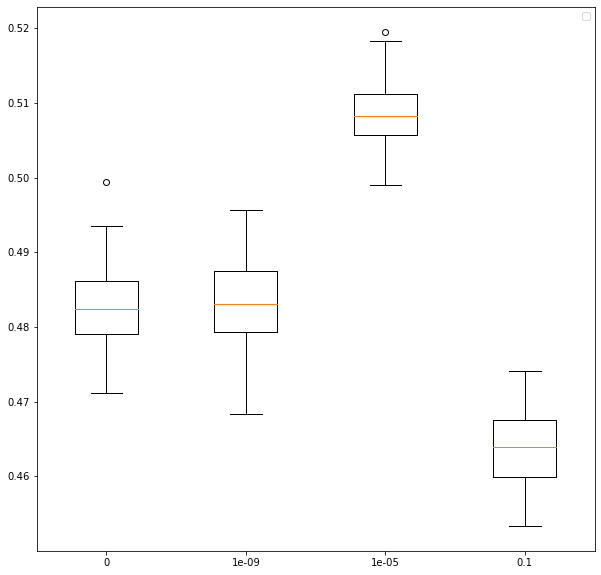

In [39]:
plt.figure(figsize=(10, 10))

plt.boxplot(TestF1Score_general)
plt.xticks([1, 2, 3, 4], ["0","1e-09","1e-05","0.1"])
plt.legend()
plt.show()

Límites [2.00000000e+00 1.00000000e+00 9.99999994e-01 ... 8.71897805e-23
 6.27620531e-23 2.14228651e-25]


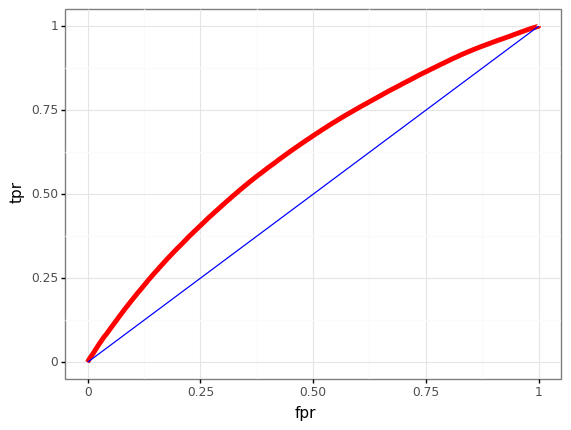


Valor del AUC: 0.6201057437248927


In [78]:
NB = GaussianNB(var_smoothing = 1e-05)
NB.fit(df_procesado, target)
fpr, tpr, thresholds = mt.roc_curve(target, NB.predict_proba(df_procesado)[:,1])
print("Límites",thresholds)

tempDF=pd.DataFrame(zip(fpr,tpr),columns=["fpr","tpr"])
#Curva ROC
print(ggplot(tempDF)+aes(x="fpr",y="tpr")+geom_line(color="red",size=2)+
    annotate("segment",x=0,y=0,xend=1,yend=1,color="blue")+
    theme_bw()
)

#Valor del AUC
print("Valor del AUC:",mt.auc(fpr,tpr))

Límites [2.00000000e+00 1.00000000e+00 9.99999994e-01 ... 8.69380323e-23
 6.25808366e-23 2.13610096e-25]


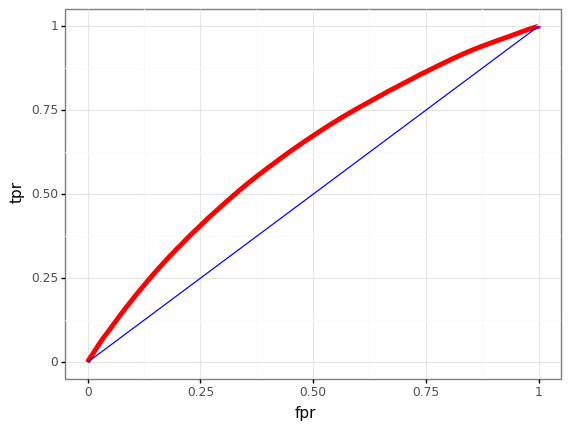


Valor del AUC: 0.6200977121220195


In [79]:
NB = GaussianNB(var_smoothing = 1e-05)
df_procesado.drop('denied_boarding', axis=1, inplace=True)
NB.fit(df_procesado, target)
fpr, tpr, thresholds = mt.roc_curve(target, NB.predict_proba(df_procesado)[:,1])
print("Límites",thresholds)

tempDF=pd.DataFrame(zip(fpr,tpr),columns=["fpr","tpr"])
#Curva ROC
print(ggplot(tempDF)+aes(x="fpr",y="tpr")+geom_line(color="red",size=2)+
    annotate("segment",x=0,y=0,xend=1,yend=1,color="blue")+
    theme_bw()
)

#Valor del AUC
print("Valor del AUC:",mt.auc(fpr,tpr))

In [31]:
from sklearn.feature_selection import RFECV

estimator = MultinomialNB(alpha = 10)
selector = RFECV(estimator, cv=5, scoring='f1')
selector = selector.fit(df_procesado[['mes','horario']], target)
display(selector.support_)
display(selector.ranking_)

array([False,  True])

array([2, 1])

In [22]:
#Crear un objeto de KFold cross validation
k = 10
kf = KFold(n_splits = k, shuffle = True)

TrainAcc_general = []
TestAcc_general = []
TrainF1Score_general = []
TestF1Score_general = []

NB = MultinomialNB()

for z in range(1,len(df_procesado.columns)+1):
    display(df_procesado.iloc[:,:z])
    
    df_final = df_procesado.iloc[:,:z]

    #Crear arreglos para guardar los errores de cada fold (tanto para entrenamiento como test).
    AccTrain = np.zeros(k)
    AccTest = np.zeros(k)
    F1Train = np.zeros(k)
    F1Test = np.zeros(k)
    
    i=0
    #Aplicar K-fold cross validation
    for train_index, test_index in kf.split(df_final):
        #extraer los datos de entrenamiento y test
            #Train
            trainData = df_procesado.iloc[train_index, :]
            trainLabel = target.iloc[train_index]
        
            yes_overbook = trainData[trainLabel == 1]
            no_overbook = trainData[trainLabel == 0]
            
            yes_overbook = yes_overbook.sample(no_overbook.shape[0])

            trainData = yes_overbook.append(no_overbook)
            trainLabel = pd.Series([1]*no_overbook.shape[0]+[0]*no_overbook.shape[0])
            
            #Test
            testData = df_procesado.iloc[test_index, :]
            testLabel = target.iloc[test_index]

            #Entrenar el modelo usando los datos de entrenamiento
            NB = NB.fit(trainData, trainLabel)

            #Predecir los valores de TrainData y calcule su error
            prediccion = NB.predict(trainData)
            F1Train[i] = mt.f1_score(trainLabel, prediccion, pos_label = 0)
            AccTrain[i] = mt.accuracy_score(trainLabel, prediccion)

            #Prediga los valores de testData y calcule su error
            prediccion = NB.predict(testData)
            F1Test[i] = mt.f1_score(testLabel, prediccion, pos_label = 0)
            AccTest[i] = mt.accuracy_score(testLabel, prediccion)

            i+=1
            
            if(i == k):
                TrainAcc_general.append(AccTrain)
                TestAcc_general.append(AccTest)
                TrainF1Score_general.append(F1Train)
                TestF1Score_general.append(F1Test)

            print(i, end=" ")
            
    print("\nAccuracy-score modelo para training: ", TrainAcc_general[len(TrainAcc_general)-1].mean(), "+-", TrainAcc_general[len(TrainAcc_general)-1].std()) 
    print("Accuracy-score modelo para test: ", TestAcc_general[len(TestAcc_general)-1].mean(), "+-", TestAcc_general[len(TestAcc_general)-1].std())
    print("F1-score modelo para training: ", TrainF1Score_general[len(TrainF1Score_general)-1].mean(), "+-", TrainF1Score_general[len(TrainF1Score_general)-1].std())   
    print("F1-score modelo para test: ", TestF1Score_general[len(TestF1Score_general)-1].mean(), "+-", TestF1Score_general[len(TestF1Score_general)-1].std())  

,fligth_number
0,3799
1,2869
2,3776
3,2267
4,3051
...,...
999885,2252
999886,2567
999887,3886
999888,3045


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.541159593113233 +- 0.00037071206255074094
Accuracy-score modelo para test:  0.5896653482382802 +- 0.001492153549371885
F1-score modelo para training:  0.4560983194126861 +- 0.0004773155371474363
F1-score modelo para test:  0.3926199997115269 +- 0.0025474155124093423


,fligth_number,distance
0,3799,1394
1,2869,489
2,3776,2180
3,2267,524
4,3051,1170
...,...,...
999885,2252,552
999886,2567,3934
999887,3886,1430
999888,3045,1091


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.5411883617786094 +- 0.00030269362080275077
Accuracy-score modelo para test:  0.5896883517387964 +- 0.0013000667070832577
F1-score modelo para training:  0.4560492297408995 +- 0.00038244371155618664
F1-score modelo para test:  0.3925602775160961 +- 0.002465317209175567


,fligth_number,distance,pax_midlow
0,3799,1394,94
1,2869,489,100
2,3776,2180,7
3,2267,524,54
4,3051,1170,21
...,...,...,...
999885,2252,552,25
999886,2567,3934,129
999887,3886,1430,2
999888,3045,1091,67


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.5411648135743634 +- 0.00027067217263516605
Accuracy-score modelo para test:  0.5897283563793325 +- 0.0010688342119547598
F1-score modelo para training:  0.45603193932298713 +- 0.0003520572316400479
F1-score modelo para test:  0.3925496069536444 +- 0.002152110542032665


,fligth_number,distance,pax_midlow,pax_high
0,3799,1394,94,2
1,2869,489,100,4
2,3776,2180,7,1
3,2267,524,54,4
4,3051,1170,21,88
...,...,...,...,...
999885,2252,552,25,12
999886,2567,3934,129,3
999887,3886,1430,2,1
999888,3045,1091,67,2


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.5409382707151585 +- 0.00036558203977129437
Accuracy-score modelo para test:  0.5896973539091985 +- 0.0020518226108861204
F1-score modelo para training:  0.45583668117732723 +- 0.0004932537040638998
F1-score modelo para test:  0.39251486691169485 +- 0.0021228382678391113


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh
0,3799,1394,94,2,28
1,2869,489,100,4,4
2,3776,2180,7,1,5
3,2267,524,54,4,7
4,3051,1170,21,88,18
...,...,...,...,...,...
999885,2252,552,25,12,20
999886,2567,3934,129,3,19
999887,3886,1430,2,1,0
999888,3045,1091,67,2,7


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.541098636671287 +- 0.0003648676212780872
Accuracy-score modelo para test:  0.5896973534090735 +- 0.0011357838788723716
F1-score modelo para training:  0.4559965497150718 +- 0.000563123080527519
F1-score modelo para test:  0.39252879957767345 +- 0.002428015013138715


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low
0,3799,1394,94,2,28,94
1,2869,489,100,4,4,87
2,3776,2180,7,1,5,64
3,2267,524,54,4,7,21
4,3051,1170,21,88,18,82
...,...,...,...,...,...,...
999885,2252,552,25,12,20,4
999886,2567,3934,129,3,19,121
999887,3886,1430,2,1,0,108
999888,3045,1091,67,2,7,42


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.5411230786334601 +- 0.0003714274565515079
Accuracy-score modelo para test:  0.5897573597997352 +- 0.0013485351681373414
F1-score modelo para training:  0.4558935191158885 +- 0.00044898776302896236
F1-score modelo para test:  0.392456413849119 +- 0.003009041979067814


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer
0,3799,1394,94,2,28,94,22
1,2869,489,100,4,4,87,25
2,3776,2180,7,1,5,64,2
3,2267,524,54,4,7,21,4
4,3051,1170,21,88,18,82,0
...,...,...,...,...,...,...,...
999885,2252,552,25,12,20,4,12
999886,2567,3934,129,3,19,121,2
999887,3886,1430,2,1,0,108,20
999888,3045,1091,67,2,7,42,16


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.541101143812291 +- 0.0001787102335041312
Accuracy-score modelo para test:  0.5897153575598304 +- 0.0011010450579850483
F1-score modelo para training:  0.45593159741994416 +- 0.00024158061063544675
F1-score modelo para test:  0.392463609733102 +- 0.0019489758536125235


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings
0,3799,1394,94,2,28,94,22,19
1,2869,489,100,4,4,87,25,0
2,3776,2180,7,1,5,64,2,0
3,2267,524,54,4,7,21,4,0
4,3051,1170,21,88,18,82,0,88
...,...,...,...,...,...,...,...,...
999885,2252,552,25,12,20,4,12,0
999886,2567,3934,129,3,19,121,2,20
999887,3886,1430,2,1,0,108,20,36
999888,3045,1091,67,2,7,42,16,0


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.54115203713646 +- 0.0002967555932054137
Accuracy-score modelo para test:  0.5897313569794356 +- 0.0015152958045839319
F1-score modelo para training:  0.45594289593418774 +- 0.0003613466484290271
F1-score modelo para test:  0.39251936938823506 +- 0.0031812113662527844


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock
0,3799,1394,94,2,28,94,22,19,0
1,2869,489,100,4,4,87,25,0,0
2,3776,2180,7,1,5,64,2,0,0
3,2267,524,54,4,7,21,4,0,0
4,3051,1170,21,88,18,82,0,88,1
...,...,...,...,...,...,...,...,...,...
999885,2252,552,25,12,20,4,12,0,0
999886,2567,3934,129,3,19,121,2,20,0
999887,3886,1430,2,1,0,108,20,36,0
999888,3045,1091,67,2,7,42,16,0,0


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.5410106417717728 +- 0.00036137160778248464
Accuracy-score modelo para test:  0.589685348257973 +- 0.0019444918207612225
F1-score modelo para training:  0.45596264123127794 +- 0.00044003434128344113
F1-score modelo para test:  0.39257356895122425 +- 0.0015073284042309352


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx
0,3799,1394,94,2,28,94,22,19,0,1
1,2869,489,100,4,4,87,25,0,0,19
2,3776,2180,7,1,5,64,2,0,0,0
3,2267,524,54,4,7,21,4,0,0,26
4,3051,1170,21,88,18,82,0,88,1,23
...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,25,12,20,4,12,0,0,64
999886,2567,3934,129,3,19,121,2,20,0,0
999887,3886,1430,2,1,0,108,20,36,0,7
999888,3045,1091,67,2,7,42,16,0,0,34


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.5410660518175631 +- 0.0004919135942490657
Accuracy-score modelo para test:  0.5897073571598552 +- 0.0016360888557277878
F1-score modelo para training:  0.455935397430505 +- 0.00047059528719702075
F1-score modelo para test:  0.3924717094716016 +- 0.002336714132717168


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx
0,3799,1394,94,2,28,94,22,19,0,1,0
1,2869,489,100,4,4,87,25,0,0,19,9
2,3776,2180,7,1,5,64,2,0,0,0,10
3,2267,524,54,4,7,21,4,0,0,26,0
4,3051,1170,21,88,18,82,0,88,1,23,3
...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,25,12,20,4,12,0,0,64,9
999886,2567,3934,129,3,19,121,2,20,0,0,118
999887,3886,1430,2,1,0,108,20,36,0,7,0
999888,3045,1091,67,2,7,42,16,0,0,34,2


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.5411709975631402 +- 0.00034744218871532424
Accuracy-score modelo para test:  0.5896583495087069 +- 0.0013911664844393865
F1-score modelo para training:  0.4561347758108284 +- 0.0004920466937660793
F1-score modelo para test:  0.392642739645385 +- 0.002696282944531716


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p
0,3799,1394,94,2,28,94,22,19,0,1,0,239
1,2869,489,100,4,4,87,25,0,0,19,9,192
2,3776,2180,7,1,5,64,2,0,0,0,10,69
3,2267,524,54,4,7,21,4,0,0,26,0,64
4,3051,1170,21,88,18,82,0,88,1,23,3,183
...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,25,12,20,4,12,0,0,64,9,0
999886,2567,3934,129,3,19,121,2,20,0,0,118,156
999887,3886,1430,2,1,0,108,20,36,0,7,0,124
999888,3045,1091,67,2,7,42,16,0,0,34,2,98


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.5411789826802059 +- 0.0002242422105765669
Accuracy-score modelo para test:  0.5896883503284438 +- 0.0013768176772139405
F1-score modelo para training:  0.4560245989024139 +- 0.0003123664997283522
F1-score modelo para test:  0.39254937233612247 +- 0.002235089595177331


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,origin_int
0,3799,1394,94,2,28,94,22,19,0,1,0,239,12
1,2869,489,100,4,4,87,25,0,0,19,9,192,79
2,3776,2180,7,1,5,64,2,0,0,0,10,69,122
3,2267,524,54,4,7,21,4,0,0,26,0,64,27
4,3051,1170,21,88,18,82,0,88,1,23,3,183,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,25,12,20,4,12,0,0,64,9,0,143
999886,2567,3934,129,3,19,121,2,20,0,0,118,156,79
999887,3886,1430,2,1,0,108,20,36,0,7,0,124,62
999888,3045,1091,67,2,7,42,16,0,0,34,2,98,53


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.5411370036181482 +- 0.00016675245464694975
Accuracy-score modelo para test:  0.5896403452179151 +- 0.000929228731565966
F1-score modelo para training:  0.45606093113242385 +- 0.00025796395051387794
F1-score modelo para test:  0.3925091967953988 +- 0.0029251689003365728


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,origin_int,destination_int
0,3799,1394,94,2,28,94,22,19,0,1,0,239,12,125
1,2869,489,100,4,4,87,25,0,0,19,9,192,79,143
2,3776,2180,7,1,5,64,2,0,0,0,10,69,122,116
3,2267,524,54,4,7,21,4,0,0,26,0,64,27,33
4,3051,1170,21,88,18,82,0,88,1,23,3,183,51,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,25,12,20,4,12,0,0,64,9,0,143,27
999886,2567,3934,129,3,19,121,2,20,0,0,118,156,79,57
999887,3886,1430,2,1,0,108,20,36,0,7,0,124,62,125
999888,3045,1091,67,2,7,42,16,0,0,34,2,98,53,126


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.5410322478014097 +- 0.00020399944526441953
Accuracy-score modelo para test:  0.5897213580998718 +- 0.0013145870991886216
F1-score modelo para training:  0.45590412294362803 +- 0.00022859400994074637
F1-score modelo para test:  0.39252570352895544 +- 0.0030613860709977157


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,origin_int,destination_int,capacidad
0,3799,1394,94,2,28,94,22,19,0,1,0,239,12,125,2
1,2869,489,100,4,4,87,25,0,0,19,9,192,79,143,2
2,3776,2180,7,1,5,64,2,0,0,0,10,69,122,116,3
3,2267,524,54,4,7,21,4,0,0,26,0,64,27,33,2
4,3051,1170,21,88,18,82,0,88,1,23,3,183,51,55,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,25,12,20,4,12,0,0,64,9,0,143,27,2
999886,2567,3934,129,3,19,121,2,20,0,0,118,156,79,57,2
999887,3886,1430,2,1,0,108,20,36,0,7,0,124,62,125,3
999888,3045,1091,67,2,7,42,16,0,0,34,2,98,53,126,2


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.5411343555579871 +- 0.00040561400736915726
Accuracy-score modelo para test:  0.5896723515389961 +- 0.0015065424224033155
F1-score modelo para training:  0.45603524049470545 +- 0.00046890905462492464
F1-score modelo para test:  0.39253290706276234 +- 0.0019626010752606623


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,origin_int,destination_int,capacidad,denied
0,3799,1394,94,2,28,94,22,19,0,1,0,239,12,125,2,1
1,2869,489,100,4,4,87,25,0,0,19,9,192,79,143,2,1
2,3776,2180,7,1,5,64,2,0,0,0,10,69,122,116,3,1
3,2267,524,54,4,7,21,4,0,0,26,0,64,27,33,2,1
4,3051,1170,21,88,18,82,0,88,1,23,3,183,51,55,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,25,12,20,4,12,0,0,64,9,0,143,27,2,1
999886,2567,3934,129,3,19,121,2,20,0,0,118,156,79,57,2,1
999887,3886,1430,2,1,0,108,20,36,0,7,0,124,62,125,3,1
999888,3045,1091,67,2,7,42,16,0,0,34,2,98,53,126,2,1


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.541142682171935 +- 0.0002815449367615648
Accuracy-score modelo para test:  0.5897513598998538 +- 0.0017892198882229504
F1-score modelo para training:  0.4559545355912974 +- 0.0004947171952713064
F1-score modelo para test:  0.39251623237531597 +- 0.0025846577409385976


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,origin_int,destination_int,capacidad,denied,booking
0,3799,1394,94,2,28,94,22,19,0,1,0,239,12,125,2,1,3
1,2869,489,100,4,4,87,25,0,0,19,9,192,79,143,2,1,3
2,3776,2180,7,1,5,64,2,0,0,0,10,69,122,116,3,1,1
3,2267,524,54,4,7,21,4,0,0,26,0,64,27,33,2,1,1
4,3051,1170,21,88,18,82,0,88,1,23,3,183,51,55,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,25,12,20,4,12,0,0,64,9,0,143,27,2,1,1
999886,2567,3934,129,3,19,121,2,20,0,0,118,156,79,57,2,1,3
999887,3886,1430,2,1,0,108,20,36,0,7,0,124,62,125,3,1,2
999888,3045,1091,67,2,7,42,16,0,0,34,2,98,53,126,2,1,2


1 2 3 4 5 6 7 8 9 10 
Accuracy-score modelo para training:  0.5409473098160259 +- 0.0002234617290064449
Accuracy-score modelo para test:  0.5897593600197589 +- 0.0015092128470137055
F1-score modelo para training:  0.455809341693171 +- 0.00031887236962291
F1-score modelo para test:  0.3925133778903051 +- 0.0025006933862744356


,fligth_number,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,origin_int,destination_int,capacidad,denied,booking,revenues_usd_discr
0,3799,1394,94,2,28,94,22,19,0,1,0,239,12,125,2,1,3,6
1,2869,489,100,4,4,87,25,0,0,19,9,192,79,143,2,1,3,2
2,3776,2180,7,1,5,64,2,0,0,0,10,69,122,116,3,1,1,8
3,2267,524,54,4,7,21,4,0,0,26,0,64,27,33,2,1,1,6
4,3051,1170,21,88,18,82,0,88,1,23,3,183,51,55,2,1,3,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,25,12,20,4,12,0,0,64,9,0,143,27,2,1,1,8
999886,2567,3934,129,3,19,121,2,20,0,0,118,156,79,57,2,1,3,10
999887,3886,1430,2,1,0,108,20,36,0,7,0,124,62,125,3,1,2,7
999888,3045,1091,67,2,7,42,16,0,0,34,2,98,53,126,2,1,2,5


1 2 3 4 

KeyboardInterrupt: 

In [32]:
res = [None] * (len(TestF1Score_general))

variables = 1
for i in range(len(TestF1Score_general)):
    res[i] = [variables, TrainAcc_general[i].mean(), TrainAcc_general[i].std(), TestAcc_general[i].mean(),TestAcc_general[i].std(), TrainF1Score_general[i].mean(),TrainF1Score_general[i].std(), TestF1Score_general[i].mean(),TestF1Score_general[i].std()]
    variables += 1

resultados = pd.DataFrame(res, columns = ['# Variables','Accuracy Train Mean', 'Accuracy Train Std','Accuracy Test Mean','Accuracy Test Std','F1 Train Mean','F1 Train std','F1 Test Mean','F1 Test Std'])
resultados

,# Variables,Accuracy Train Mean,Accuracy Train Std,Accuracy Test Mean,Accuracy Test Std,F1 Train Mean,F1 Train std,F1 Test Mean,F1 Test Std
0,1,0.588093,0.000473,0.576696,0.002059,0.602283,0.001557,0.503873,0.001902
1,2,0.588172,0.000446,0.577798,0.002711,0.601580,0.001790,0.503824,0.001513
2,3,0.587856,0.000652,0.576927,0.002319,0.601843,0.001667,0.503744,0.001788
3,4,0.587915,0.000447,0.577036,0.002838,0.602083,0.001728,0.504142,0.001485
4,5,0.587961,0.000333,0.577385,0.002226,0.601671,0.001623,0.503848,0.001043
5,6,0.588119,0.000373,0.577618,0.002004,0.601585,0.001486,0.503784,0.001703
6,7,0.587749,0.000345,0.576664,0.002242,0.602165,0.001219,0.504011,0.001566
7,8,0.588221,0.000635,0.577555,0.002009,0.601711,0.001661,0.503700,0.001869
8,9,0.588168,0.000408,0.578183,0.002359,0.601081,0.001325,0.503475,0.001945
9,10,0.587987,0.000459,0.576515,0.002455,0.602437,0.001273,0.503974,0.001603


<Figure size 720x720 with 0 Axes>

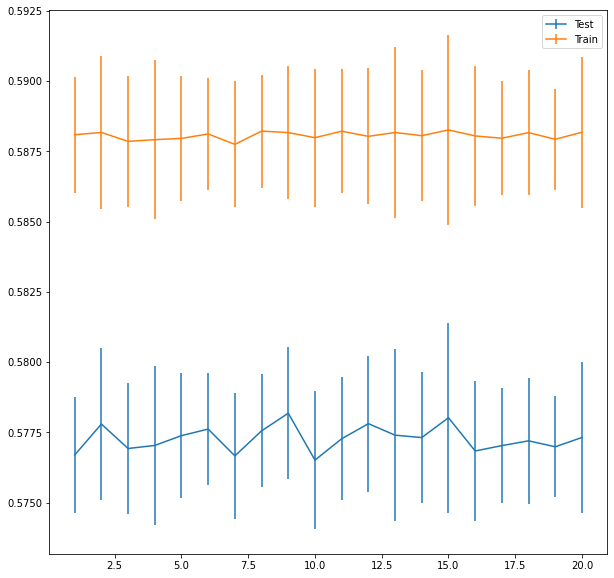

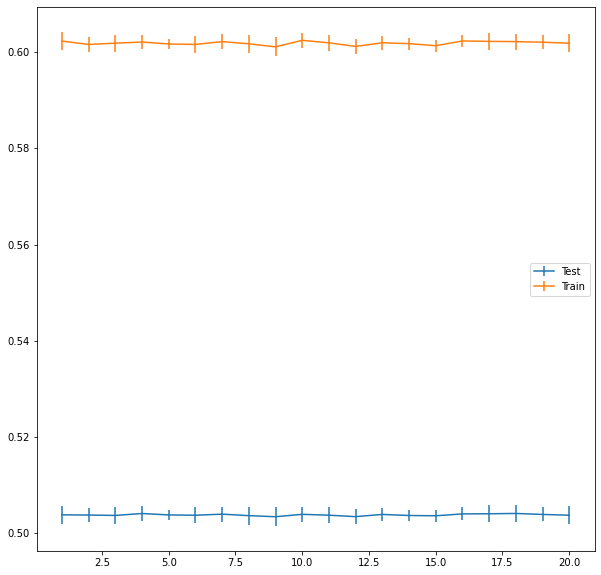

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

plt.figure(figsize=(10, 10))
plt.errorbar(resultados["# Variables"], resultados["Accuracy Test Mean"], resultados["Accuracy Test Std"], label = "Test")
plt.errorbar(resultados["# Variables"], resultados["Accuracy Train Mean"], resultados["Accuracy Test Std"], label = "Train")
plt.legend()
plt.show()

plt.figure(figsize=(10, 10))
plt.errorbar(resultados["# Variables"], resultados["F1 Test Mean"], resultados["F1 Test Std"], label = "Test")
plt.errorbar(resultados["# Variables"], resultados["F1 Train Mean"], resultados["F1 Test Std"], label = "Train")
plt.legend()
plt.show()

17
Límites [2.0e+000 1.0e+000 1.0e+000 ... 3.6e-322 1.5e-323 0.0e+000]


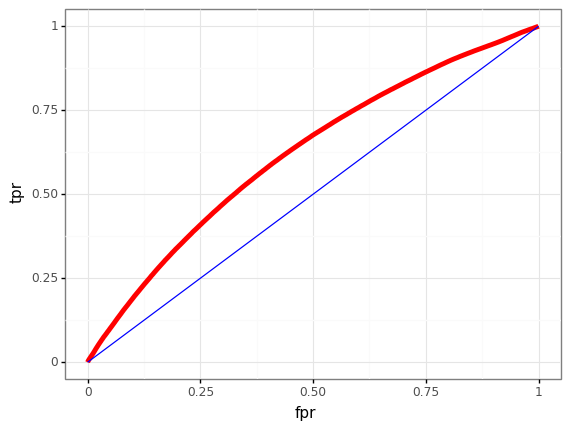


Valor del AUC: 0.6205706767181011


In [51]:
from sklearn import metrics as mt
#df_final = df_procesado[columnas.Variable].iloc[:,:i]
#Calculando los tpr and fpr
NB = GaussianNB()
print(i)
NB.fit(df_procesado, target)
fpr, tpr, thresholds = mt.roc_curve(target, NB.predict_proba(df_procesado)[:,1])
print("Límites",thresholds)

tempDF=pd.DataFrame(zip(fpr,tpr),columns=["fpr","tpr"])
#Curva ROC
print(ggplot(tempDF)+aes(x="fpr",y="tpr")+geom_line(color="red",size=2)+
    annotate("segment",x=0,y=0,xend=1,yend=1,color="blue")+
    theme_bw()
)

#Valor del AUC
print("Valor del AUC:",mt.auc(fpr,tpr))

In [40]:
df_procesado[['distance', 'pax_midlow', 'pax_high', 'pax_midhigh','pax_low', 'pax_freqflyer', 'group_bookings', 'out_of_stock', 'dom_cnx','int_cnx', 'p2p']]

,distance,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p
0,1394,94,2,28,94,22,19,0,1,0,239
1,489,100,4,4,87,25,0,0,19,9,192
2,2180,7,1,5,64,2,0,0,0,10,69
3,524,54,4,7,21,4,0,0,26,0,64
4,1170,21,88,18,82,0,88,1,23,3,183
...,...,...,...,...,...,...,...,...,...,...,...
999885,552,25,12,20,4,12,0,0,64,9,0
999886,3934,129,3,19,121,2,20,0,0,118,156
999887,1430,2,1,0,108,20,36,0,7,0,124
999888,1091,67,2,7,42,16,0,0,34,2,98


In [110]:
res = [None] * (len(TestF1Score_general))

variables = [0,1e-09,1e-05,0.1]
for i in range(len(TestF1Score_general)):
    res[i] = [variables[i], TrainF1Score_general[i],TrainF1Score_general[i], TestF1Score_general[i].mean(),TestF1Score_general[i].std()]

resultados = pd.DataFrame(res, columns = ['Var_Smooth','Accuracy Train Mean', 'Accuracy Train Std','Accuracy Test Mean','Accuracy Test Std','F1 Train Mean','F1 Train std','F1 Test Mean','F1 Test Std'])
resultados

ValueError: 9 columns passed, passed data had 5 columns

# Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

#Crear un objeto de KFold cross validation

#for k in range (2,100, 5):
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

#Crear arreglos para guardar los errores de cada fold (tanto para entrenamiento como test).
F1Train = np.zeros(5)
F1Test = np.zeros(5)

LR = LogisticRegression(max_iter = 2000)
i=0

#Aplicar K-fold cross validation
for train_index, test_index in kf.split(df_procesado):
        #extraer los datos de entrenamiento y test
        trainData = df_procesado.iloc[train_index, :]
        testData = df_procesado.iloc[test_index, :]

        trainLabel = target.iloc[train_index]
        testLabel = target.iloc[test_index]

        #Entrenar el modelo usando los datos de entrenamiento
        LR = LR.fit(trainData, trainLabel)
        
        #Predecir los valores de TrainData y calcule su error
        prediccion = LR.predict(trainData)
        F1Train[i] = mt.f1_score(trainLabel, prediccion, pos_label = 0)
    
        #Prediga los valores de testData y calcule su error
        prediccion = LR.predict(testData)
        F1Test[i] = mt.f1_score(testLabel, prediccion, pos_label = 0)

        i+=1

        print(i, end = " ")
print("\nF1-score modelo para training: ", F1Train.mean(), "+-", F1Train.std())   
print("F1-score modelo para test: ", F1Test.mean(), "+-", F1Test.std())  

1 2 3 4 5 
F1-score modelo para training:  0.10186918570694592 +- 0.0057630979067868
F1-score modelo para test:  0.10173555250847224 +- 0.005514475847260418


Límites [1.92780458 0.92780458 0.9179111  ... 0.04342799 0.04300224 0.02239531]


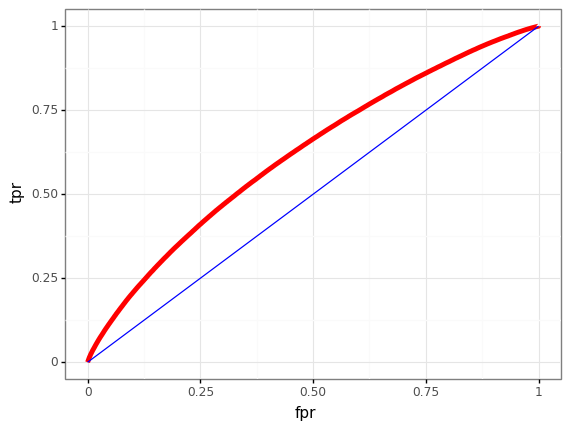


Valor del AUC: 0.6202874284252193


In [35]:
#Calculando los tpr and fpr
from sklearn import metrics as mt
fpr, tpr, thresholds = mt.roc_curve(target, LR.predict_proba(df_procesado)[:,1])
print("Límites",thresholds)

tempDF=pd.DataFrame(zip(fpr,tpr),columns=["fpr","tpr"])
#Curva ROC
print(ggplot(tempDF)+aes(x="fpr",y="tpr")+geom_line(color="red",size=2)+
    annotate("segment",x=0,y=0,xend=1,yend=1,color="blue")+
    theme_bw()
)

#Valor del AUC
print("Valor del AUC:",mt.auc(fpr,tpr))

In [79]:
def procesar_csv(df):
    from sklearn import preprocessing
    
    # Convertirmos las columnas origin y destination a variables numericas 
    le = preprocessing.LabelEncoder()
    ciudades = ((pd.concat([df['origin'], df['destination']], ignore_index = True).drop_duplicates()).reset_index())[0]
    le.fit(ciudades)
    
    origin_as_int = le.fit_transform(df['origin'])
    destination_as_int = le.fit_transform(df["destination"])
    
    df["origin_int"] = origin_as_int
    df.drop('origin', axis=1, inplace=True)
    
    df["destination_int"] = destination_as_int
    df.drop('destination', axis=1, inplace=True)

    df["p2p"] = np.where(df["p2p"] > 0, 1,0)
    df["pax_midlow"] = np.where(df["pax_midlow"] > 0, 1,0)
    df["pax_high"] = np.where(df["pax_high"] > 0, 1,0)
    df["pax_midhigh"] = np.where(df["pax_midhigh"] > 0, 1,0)
    df["pax_low"] = np.where(df["pax_low"] > 0, 1,0)
    df["pax_freqflyer"] = np.where(df["pax_freqflyer"] > 0, 1,0)
    df["group_bookings"] = np.where(df["group_bookings"] > 0, 1,0)
    df["dom_cnx"] = np.where(df["dom_cnx"] > 0, 1,0)
    df["int_cnx"] = np.where(df["int_cnx"] > 0, 1,0)
    
    
    # Transformamos Columnas Continuas a Discretas
    revenues_usd_discr = pd.qcut(df["revenues_usd"], 10, [1,2,3,4,5,6,7,8,9,10] )
    df["revenues_usd_discr"] = revenues_usd_discr
    df.drop('revenues_usd', axis=1, inplace=True)
    
    # Cambiamos el formato del date y departure_time para saber el mes de la compra y el horario en el que se compra
    df["date"] = pd.to_datetime(df["date"], errors='coerce')
    df["mes"] = pd.DatetimeIndex(df["date"]).month
    
    df.departure_time = pd.to_datetime(df.departure_time, errors='coerce')
    bins = [0,12,18,24]
    labels = [1,2,3]
    df['horario'] = pd.cut(df["departure_time"].dt.hour, bins, labels=labels, right=False)
    
    
    df.drop('departure_time', axis=1, inplace=True)
    df.drop('date', axis=1, inplace=True)
    
    # Eliminar columnas sin uso
    df.drop('Unnamed: 0', axis=1, inplace=True)
    
    # retornamos el data frame modificado sin valore nulos.
    return df.dropna()

In [6]:
from sklearn.feature_selection import RFECV
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB(alpha=10)

selector = RFECV(NB, step=1, cv=10,scoring='f1')
selector = selector.fit(df_procesado, target)

resultados = [None] * 20

for k in range(20):
    resultados[k] = df_procesado.columns[k],selector.support_[k],selector.ranking_[k]

columnas = pd.DataFrame(resultados, columns = ['Variable','Support', 'Ranking'])
columnas = columnas.sort_values(by=['Ranking'])
columnas

,Variable,Support,Ranking
8,out_of_stock,True,1
19,horario,False,2
15,denied,False,3
16,booking,False,4
14,capacidad,False,5
7,group_bookings,False,6
3,pax_high,False,7
17,revenues_usd_discr,False,8
4,pax_midhigh,False,9
18,mes,False,10


Optimal number of features : 1


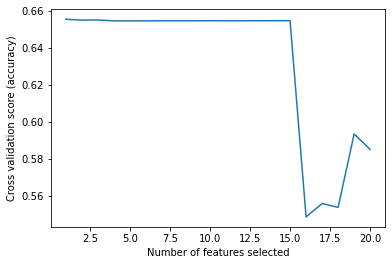

In [81]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification


# Create the RFE object and compute a cross-validated score.
NB = MultinomialNB(alpha = 100)
# The "accuracy" scoring shows the proportion of correct classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=NB,
    step=1,
    cv=StratifiedKFold(2),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(df_procesado, target)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [24]:
from sklearn.feature_selection import RFE

#for k in range (2,100, 5):
kf = KFold(n_splits = 2, shuffle = True, random_state = 42)

NB = MultinomialNB(alpha = 10)
i=0

#Aplicar K-fold cross validation
for train_index, test_index in kf.split(df_procesado):
    
        #extraer los datos de entrenamiento y test
        trainData = df_procesado.iloc[train_index, :]
        trainLabel = target.iloc[train_index]

        yes_overbook = trainData[trainLabel == 1]
        no_overbook = trainData[trainLabel == 0]

        yes_overbook = yes_overbook.sample(no_overbook.shape[0])

        trainData = yes_overbook.append(no_overbook)
        trainLabel = pd.Series([1]*no_overbook.shape[0]+[0]*no_overbook.shape[0])

        testData = df_procesado.iloc[test_index, :]
        testLabel = target.iloc[test_index]

        rfe = RFE(NB)
        rfe = rfe.fit(trainData, trainLabel)
        i+=1

resultados = [None] * 20

for k in range(20):
    resultados[k] = df_procesado.columns[k],rfe.support_[k],rfe.ranking_[k]

columnas = pd.DataFrame(resultados, columns = ['Variable','Support', 'Ranking'])
columnas = columnas.sort_values(by=['Ranking'])
columnas

,Variable,Support,Ranking
19,horario,True,1
17,revenues_usd_discr,True,1
16,booking,True,1
3,pax_high,True,1
4,pax_midhigh,True,1
15,denied,True,1
7,group_bookings,True,1
8,out_of_stock,True,1
18,mes,True,1
14,capacidad,True,1
